Liz's Results are in http://crick.bio.uci.edu/erebboah/postnatal_splitseq/adrenal/ENCSR193PLQ/ I should use the unfiltered?

In [1]:
import csv
from collections import Counter
import scanpy
import pysam
from pathlib import Path
import pandas
import requests
import numpy
import os
import re
import shutil
import scipy
import gzip
import sys
from matplotlib import pyplot
import matplotlib
import upsetplot
import warnings
from urllib.parse import urljoin
import yaml

In [2]:
EC = str(Path("~/proj/encoded_client").expanduser())
if EC not in sys.path:
    sys.path.append(EC)
from encoded_client import ENCODED

In [3]:
MEX = str(Path("~/proj/mex_gene_archive").expanduser())
if MEX not in sys.path:
    sys.path.append(MEX)
from mex_gene_archive.filter import write_filtered_mtx
from mex_gene_archive.reader import read_mex_archive_as_anndata

In [4]:
WRS = str(Path("~/proj/woldlab-rna-seq").expanduser())
if WRS not in sys.path:
    sys.path.append(WRS)
from woldrnaseq.plots.scrna_matrix_qc import (
    calculate_qc,
    generate_violin_plot,
    make_pct_mt_scatter,
    make_gene_by_count_scatter,
)


In [5]:
from common import scanpy_load_solo_mtx

In [6]:
def calculate_qc(adata, gene_name="gene_name"):
    mt_prefix = re.compile("^mt[-_]", re.I)
    adata.var["mt"] = adata.var[gene_name].apply(lambda x: mt_prefix.match(x) is not None)
    scanpy.pp.calculate_qc_metrics(
        adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
    )


In [7]:
%matplotlib inline

In [8]:
star_analysis_dir = Path("adrenal/mouse_adr_2k_a18m_m1")
erebboah_base_url = "http://crick.bio.uci.edu/erebboah/postnatal_splitseq/adrenal/A_18m_M_1"
#erebboah_base = "http://crick.bio.uci.edu/erebboah/postnatal_splitseq/adrenal/A_10_F_1"
#erebboah_base = "http://crick.bio.uci.edu/erebboah/postnatal_splitseq/adrenal/A_4_F_1"
erebboah_filtered = erebboah_base_url + "/DGE_filtered/"
erebboah_raw = erebboah_base_url + "/DGE_unfiltered/"

In [9]:
sj_raw = read_mex_archive_as_anndata(star_analysis_dir / "SJ_Unique_raw.tar.gz")

print("count sum", sj_raw.X.sum().sum())
print("shape", sj_raw.shape)
sj_raw

count sum 19171.0
shape (442368, 13278)


AnnData object with n_obs × n_vars = 442368 × 13278
    var: 'contig', 'start', 'end', 'strand', 'intron_motif', 'annotated', 'unique', 'multi', 'overhang'
    uns: 'type', 'output_type', 'software_version', 'arguments', 'experiment_accession', 'description', 'library_accession'

In [10]:
myrun = read_mex_archive_as_anndata(star_analysis_dir / "GeneFull_Ex50pAS_Unique_filtered.tar.gz")
calculate_qc(myrun, "gene_symbols")

print("count sum", myrun.X.sum().sum())
print("shape", myrun.shape)
myrun

count sum 218259.0
shape (847, 81881)


AnnData object with n_obs × n_vars = 847 × 81881
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_symbols', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'type', 'output_type', 'software_version', 'arguments', 'experiment_accession', 'description', 'library_accession'

In [11]:
myrunem = read_mex_archive_as_anndata(star_analysis_dir / "GeneFull_Ex50pAS_EM_filtered.tar.gz")
calculate_qc(myrunem, "gene_symbols")

print("count sum", myrunem.X.sum().sum())
print("shape", myrunem.shape)

count sum 225541.98
shape (847, 81881)


In [12]:
myrun_raw = read_mex_archive_as_anndata(star_analysis_dir / "GeneFull_Ex50pAS_Unique_raw.tar.gz")
calculate_qc(myrun_raw, "gene_symbols")

print("count sum", myrun_raw.X.sum().sum())
print("shape", myrun_raw.shape)

count sum 327967.0
shape (442368, 81881)


In [13]:
myrunem_raw = read_mex_archive_as_anndata(star_analysis_dir / "GeneFull_Ex50pAS_EM_raw.tar.gz")
calculate_qc(myrunem_raw, "gene_symbols")

print("count sum", myrunem_raw.X.sum().sum())
print("shape", myrunem_raw.shape)

count sum 338363.0
shape (442368, 81881)


In [14]:
assert myrun.shape[1] == myrunem.shape[1]
assert myrunem.shape[1] == myrun_raw.shape[1]
assert myrun_raw.shape[1] == myrunem_raw.shape[1]

In [15]:
assert sj_raw.shape[0] == myrunem_raw.shape[0]
assert myrunem_raw.shape[0] == myrun_raw.shape[0]

In [16]:
def load_uci(url):
    req = requests.get(urljoin(url, "DGE.mtx"), stream=True)
    X = scipy.io.mmread(req.raw)
    adata = scanpy.AnnData(X.tocsr())
    print("Matrix shape", adata.shape)
    
    cell_metadata = pandas.read_csv(urljoin(url, "cell_metadata.csv"), index_col=0)
    print("obs (cell) metadata shape", cell_metadata.shape)
    adata.obs_names = cell_metadata["cell_barcode"]
    
    genes = pandas.read_csv(urljoin(url, "genes.csv"), index_col=0)
    print("var (gene) metadata shape", cell_metadata.shape)

    adata.var_names = genes["gene_id"]
    adata.var["gene_name"] = genes["gene_name"].values

    mt_prefix = re.compile("^mt[-_]", re.I)
    adata.var["mt"] = adata.var["gene_name"].apply(lambda x: mt_prefix.match(x) is not None)
    scanpy.pp.calculate_qc_metrics(
        adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
    )

    return adata



In [17]:
ucirun = load_uci(erebboah_raw)

print("uci count sum", ucirun.X.sum().sum())
print("uci", ucirun)

Matrix shape (5442, 13332)
obs (cell) metadata shape (5442, 9)
var (gene) metadata shape (5442, 9)
uci count sum 338505.0
uci AnnData object with n_obs × n_vars = 5442 × 13332
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'


In [18]:
cell_metadata = pandas.read_csv(urljoin(erebboah_raw, "cell_metadata.csv"), index_col=0)
ucirun.obs_names = cell_metadata["cell_barcode"]
cell_metadata.head()

,cell_barcode,species,sample,rnd1_well,rnd2_well,rnd3_well,umi_count,umi_count_50dup,gene_count
0,ATCATTCCATAGCGAC_11,mm10,A_18m_M_1,11,79,80,15311,10721.363972,4364
1,TGGCTTCATCTTCACA_23,mm10,A_18m_M_1,23,62,65,15256,10682.850810,4397
2,TGGCTTCAGAACAGGC_11,mm10,A_18m_M_1,11,91,65,7645,5353.329473,3041
3,CACCTTACGCTCGGTA_23,mm10,A_18m_M_1,23,52,83,7027,4920.581584,2813
4,GGTGCGAAAGCCATGC_11,mm10,A_18m_M_1,11,77,54,5973,4182.529358,2704


In [19]:
genes = pandas.read_csv(urljoin(erebboah_raw, "genes.csv"), index_col=0)
genes

,gene_id,gene_name,genome
0,ENSMUSG00000000001.4,Gnai3,mm10
1,ENSMUSG00000000031.16,H19,mm10
2,ENSMUSG00000000049.11,Apoh,mm10
3,ENSMUSG00000000056.7,Narf,mm10
4,ENSMUSG00000000058.6,Cav2,mm10
...,...,...,...
13327,ENSMUSG00000118346.1,Tmem179b,mm10
13328,ENSMUSG00000118362.1,AC116597.1,mm10
13329,ENSMUSG00000118369.1,AC133451.2,mm10
13330,ENSMUSG00000118380.1,AC131675.3,mm10


In [20]:
ucirun.var_names = genes["gene_id"]
ucirun.var["gene_name"] = genes["gene_name"].values

In [21]:
mt_prefix = re.compile("^mt[-_]", re.I)
ucirun.var["mt"] = ucirun.var["gene_name"].apply(lambda x: mt_prefix.match(x) is not None)
scanpy.pp.calculate_qc_metrics(
    ucirun, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)


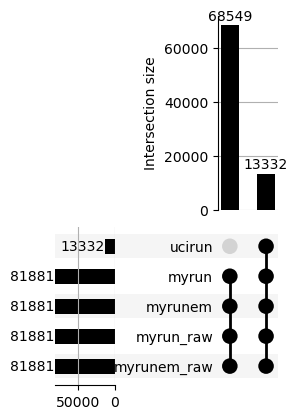

In [22]:
upset_gene_contents = upsetplot.from_contents({
    'myrun': myrun.var_names,
    'myrunem': myrunem.var_names,
    'myrun_raw': myrun_raw.var_names,
    'myrunem_raw': myrunem_raw.var_names,
    'ucirun': ucirun.var_names,
})
f = pyplot.figure(dpi=100)
_ = upsetplot.plot(upset_gene_contents, fig=f, show_counts=True)

In [23]:
len(set(myrun.obs_names)), myrun.obs_names.shape

(847, (847,))

In [24]:
len(set(ucirun.obs_names)), ucirun.obs_names.shape

(5442, (5442,))

In [25]:
#myrun_expressed = myrun_raw[myrun_raw.obs["total_counts"] > 0]
#myrunem_expressed =  myrunem_raw[myrunem_raw.obs["total_counts"] > 0]


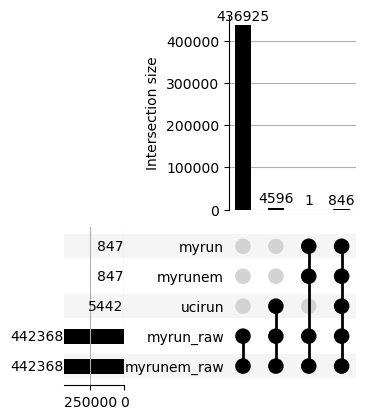

In [26]:
upset_barcode_contents = upsetplot.from_contents({
    'myrun': myrun.obs_names,
    'myrunem': myrunem.obs_names,
    'myrun_raw': myrun_raw.obs_names,
    'myrunem_raw': myrunem_raw.obs_names,
    'ucirun': set(ucirun.obs_names),
})
f = pyplot.figure(dpi=100)
_ = upsetplot.plot(upset_barcode_contents, fig=f, show_counts=True)

In [27]:
warnings.filterwarnings("ignore", "Vertical orientation")

# STAR Violin

... storing 'gene_symbols' as categorical


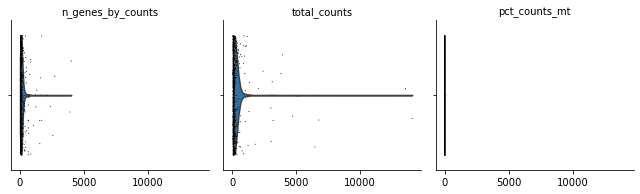

In [28]:
ag = generate_violin_plot(myrun)

# STAR Violin EM

... storing 'gene_symbols' as categorical


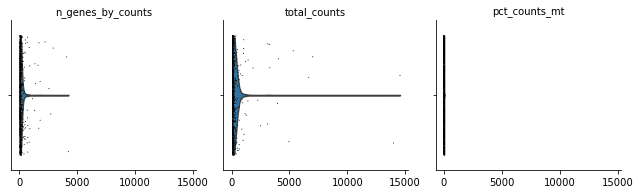

In [29]:
ag = generate_violin_plot(myrunem)

# UCI Violin

... storing 'gene_name' as categorical


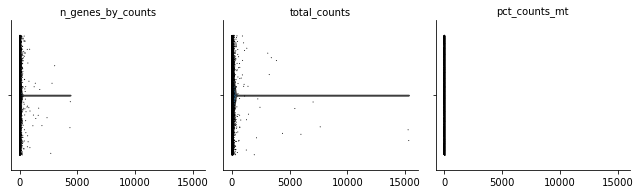

In [30]:
ag = generate_violin_plot(ucirun)

# STAR pct mt

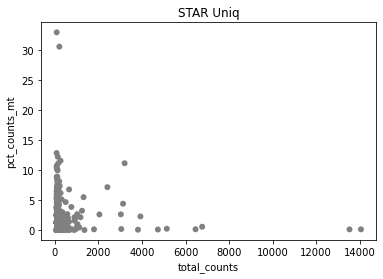

In [31]:
f = make_pct_mt_scatter(myrun, "STAR Uniq")

# STAR EM pct mt

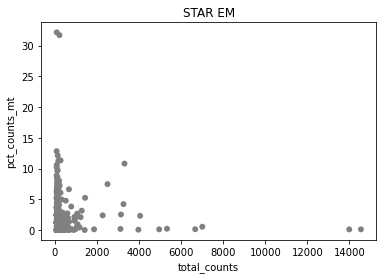

In [32]:
f = make_pct_mt_scatter(myrunem, "STAR EM")

# UCI pct mt

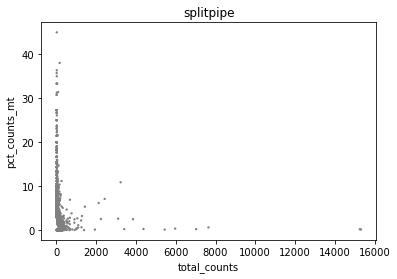

In [33]:
f = make_pct_mt_scatter(ucirun, "splitpipe")

# STAR gene by count

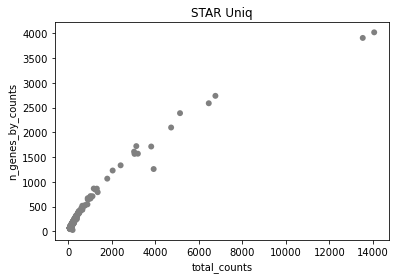

In [34]:
f = make_gene_by_count_scatter(myrun, "STAR Uniq")

# STAR EM gene by count

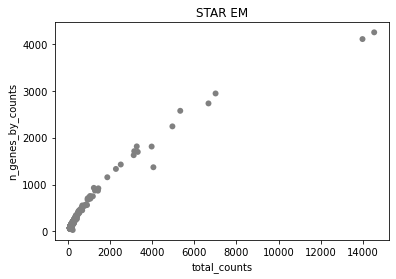

In [35]:
f = make_gene_by_count_scatter(myrunem, "STAR EM")

# UCI gene by count

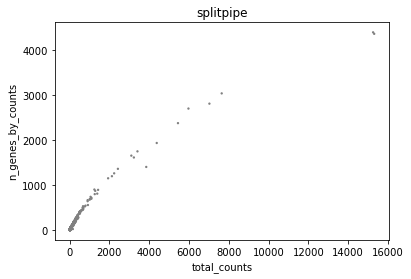

In [36]:
f = make_gene_by_count_scatter(ucirun, "splitpipe")

# STAR highest genes

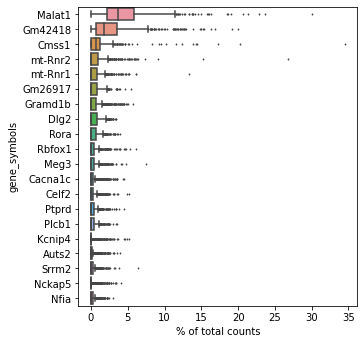

In [37]:
scanpy.pl.highest_expr_genes(myrun, n_top=20, gene_symbols="gene_symbols")

# STAR EM highest genes

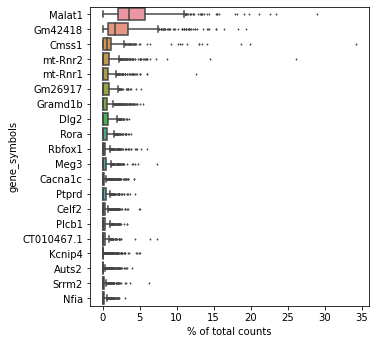

In [38]:
scanpy.pl.highest_expr_genes(myrunem, n_top=20, gene_symbols="gene_symbols")

# UCI highest genes

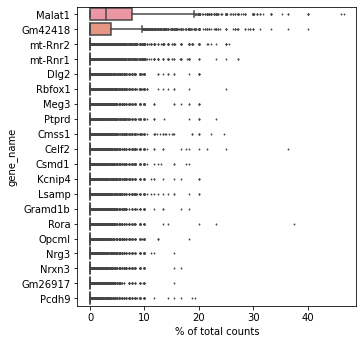

In [39]:
scanpy.pl.highest_expr_genes(ucirun, n_top=20, gene_symbols="gene_name")

# STAR expression sum

In [40]:
myrun.X.sum()

218259.0

In [41]:
myrun_raw.X.sum()

327967.0

# STAR EM expression sum

In [42]:
myrunem.X.sum()

225541.98

In [43]:
myrunem_raw.X.sum()

338363.0

# UCI expression sum

In [44]:
ucirun.X.sum()

338505.0

# WARNING

There are duplicate UCI barcodes after making them compatible with star. I think they had a _pbN after them. This code ends up using the first of the barcodes to compare with the STAR run.

In [45]:
ucirun.obs_names_make_unique()

In [46]:
def compute_spearman_pandas(left, right):
    assert left.shape == right.shape, "Shapes must be the same"

    cors=[]
    for c in left.columns:
        cors.append(scipy.stats.spearmanr(left[c], right[c])[0])
    cors = pandas.Series(cors, index=left.columns)
    return cors


In [47]:
def compute_correlations(tables):
    programs = list(tables.keys())
    cell_correlations = {}

    for name_x in programs:
        for name_y in programs[programs.index(name_x):]:
            assert tables[name_x].shape == tables[name_y].shape
            cs_cors = compute_spearman_pandas(tables[name_x], tables[name_y])
            assert len(cs_cors) == len(tables[name_x].columns)
            cell_correlations.setdefault(name_x, {})[name_y] = cs_cors
    return cell_correlations

In [48]:
def set_all_spines(ax, state):
    for name in ["left", "right", "top", "bottom"]:
        ax.spines[name].set_visible(state)
        ax.tick_params(
            axis='both', 
            which='both', 
            bottom=False,
            labelbottom=False, 
            top=False, 
            labeltop=False,
            right=False,
            labelright=False,
            left=False, 
            labelleft=False)

def plot_cell_correlation_histogram(
    table, *, programs=None, bins=50, y_annot=0.6, count_nans=False, 
    correlation_name='Spearman',
    xlim=None
):
    #fontname = 'Arial'
    override_labels = {
        'Alevin': 'Salmon Alevin (EM)',
        'Kallisto EM': 'Kallisto Bus (EM)'
    }
    fontname = 'DejaVu Sans'
    fontsize = 14    
    if programs is None:
        programs = list(table.keys())
    cell_hists = {}
    f = pyplot.figure(figsize=(7,7))
    #f.suptitle('Per-cell {} correlation'.format(correlation_name), fontsize=fontsize)
    plot_size = len(programs)-1

    axes = f.subplots(plot_size, plot_size, sharex=True, sharey=True)
    
    for i in range(0, plot_size):
        for j in range(i+1, plot_size):
            set_all_spines(axes[i, j], False)

    if plot_size == 1:
        axes = numpy.asarray([[axes]])

    for x, name_x in enumerate(programs):
        for y, name_y in enumerate(programs[programs.index(name_x)+1:]):
            x_label = override_labels.get(name_x, name_x)
            y_label = override_labels.get(name_y, name_y)
            #plot_index = plot_size * (y+x) + x + 1
            #ax = f.add_subplot(plot_size, plot_size, plot_index)
            ax = axes[y+x, x]
            if xlim is not None:
                ax.set_xlim(xlim)
            #set_all_spines(ax, True)
            if x == 0:
                ax.set_ylabel(y_label, fontname=fontname, fontsize=fontsize)

            spearman = table[name_x][name_y]
            spearman = numpy.array(spearman)
            spearman = spearman[~numpy.isnan(spearman)]
            count = len(spearman)
            median = numpy.median(spearman)
            mean = numpy.mean(spearman)
            cell_hists.setdefault(name_x, {})[name_y] = ax.hist(spearman, bins=bins, density=True)
            nantext=""
            if count_nans:
                nantext="\nNaNs {}".format(table[name_x][name_y].isna().sum())
            ax.annotate(f'Mean {mean:0.2}\nMedian {median:0.2}\nCells {count}{nantext}', xy=(0.1, y_annot), xycoords='axes fraction')
            #ax.annotate(f'Mean {mean}\nMedian {median}\nCells {count}{nantext}', xy=(0.1, y_annot), xycoords='axes fraction')
    for y in range(plot_size):
        x_label = override_labels.get(programs[y], programs[y])
        axes[0, y].set_title(x_label, fontname=fontname, fontsize=fontsize)
        axes[plot_size-1, y].set_xlabel(x_label, fontname=fontname, fontsize=fontsize)
    #f.tight_layout()
    return f

In [49]:
common_cell_set = set(ucirun.obs_names).intersection(myrun.obs_names)
common_gene_set = set(ucirun.var_names).intersection(myrun.var_names)

common_cells = [x for x in ucirun.obs_names if x in common_cell_set]
common_genes = [x for x in ucirun.var_names if x in common_gene_set]

In [50]:
ucirun.obs_names

Index(['ATCATTCCATAGCGAC_11', 'TGGCTTCATCTTCACA_23', 'TGGCTTCAGAACAGGC_11',
       'CACCTTACGCTCGGTA_23', 'GGTGCGAAAGCCATGC_11', 'AACTCACCAACGCTTA_11',
       'ACGTATCAGACTAGTA_11', 'AAGAGATCACAAGCTA_23', 'CGACACACAACAACCA_11',
       'GACAGTGCGTCGTAGA_11',
       ...
       'GTGTTCTACCGAAGTA_11', 'CAAGACTAAGTACAAG_23', 'GTGTTCTAGCCACATA_11',
       'CGACACACACATTGGC_11', 'GTGTTCTACGCATACA_23', 'AATCCGTCGAATCTGA_11',
       'CGACACACAACCGAGA_23', 'AACTCACCCAATGGAA_23', 'CTGGCATAGTGTTCTA_23',
       'CGAACTTATGGTGGTA_23'],
      dtype='object', name='cell_barcode', length=5442)

In [51]:
myrun[common_cells,common_genes]

View of AnnData object with n_obs × n_vars = 846 × 13332
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_symbols', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'type', 'output_type', 'software_version', 'arguments', 'experiment_accession', 'description', 'library_accession'

In [52]:
datasets = {
    "my": myrun[common_cells, common_genes].to_df().T,
    "my em": myrunem[common_cells, common_genes].to_df().T,
    "ucirun": ucirun[common_cells, common_genes].to_df().T,
}

cors = compute_correlations(datasets)

# All vs All filtered Spearman Correlation

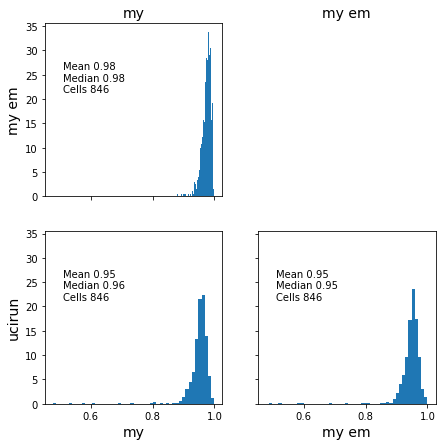

In [53]:
f = plot_cell_correlation_histogram(cors)

# All vs All less filtered Spearman Correlation calculation

In [54]:
raw_common_cell_set = set(ucirun.obs_names).intersection(myrun_raw.obs_names)
raw_common_gene_set = set(ucirun.var_names).intersection(myrun_raw.var_names)

raw_common_cells = [x for x in ucirun.obs_names if x in raw_common_cell_set]
raw_common_genes = [x for x in ucirun.var_names if x in raw_common_gene_set]

raw_datasets = {
    "my": myrun_raw[raw_common_cells, raw_common_genes].to_df().T,
    "my em raw": myrunem_raw[raw_common_cells, raw_common_genes].to_df().T,
    "ucirun": ucirun[raw_common_cells, raw_common_genes].to_df().T,
}

raw_cors = compute_correlations(raw_datasets)

In [55]:
myrun_raw[raw_common_cells, :].X.sum(), myrun_raw[:, raw_common_genes].X.sum(), myrun_raw[raw_common_cells, raw_common_genes].X.sum()

(327613.0, 326885.0, 326536.0)

# All vs All less filtered Spearman Correlation

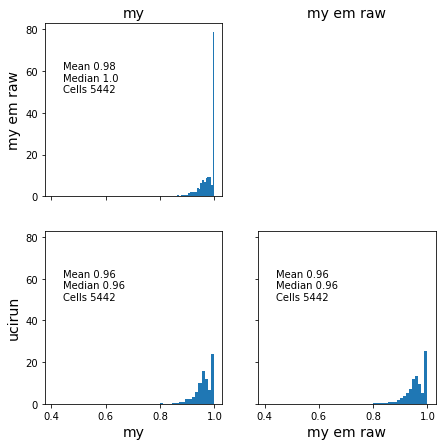

In [56]:
f = plot_cell_correlation_histogram(raw_cors)

In [57]:
myrun[:, myrun.var["total_counts"] > 0]

View of AnnData object with n_obs × n_vars = 847 × 12195
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_symbols', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'type', 'output_type', 'software_version', 'arguments', 'experiment_accession', 'description', 'library_accession'

In [58]:
myrun_raw[:, myrun_raw.var["total_counts"] > 0]

View of AnnData object with n_obs × n_vars = 442368 × 13043
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_symbols', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'type', 'output_type', 'software_version', 'arguments', 'experiment_accession', 'description', 'library_accession'

In [59]:
myrun_raw[myrun_raw.obs["total_counts"]>0]

View of AnnData object with n_obs × n_vars = 5452 × 81881
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_symbols', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'type', 'output_type', 'software_version', 'arguments', 'experiment_accession', 'description', 'library_accession'

In [60]:
ucirun[ucirun.obs["total_counts"]>0]

View of AnnData object with n_obs × n_vars = 5442 × 13332
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'